# part0: imports

In [4]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.mouse_defs
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(dt)
    reload(defs)
    reload(params)
finally:
    os.chdir(nbPath)
    
print('Done!')

Done!


# reading data

In [5]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root/animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = defs.prep_general_mouse(df)
    AllDFs.append(df)

clear_output()

# Tests on a single session

In [6]:
df = AllDFs[0]
# df_ = prep_general_mouse(df)
# df = pyal.select_trials(df, df.trialType== 'sp');
# df['target_id'] = np.remainder(df['blNumber'].to_numpy(), 4)

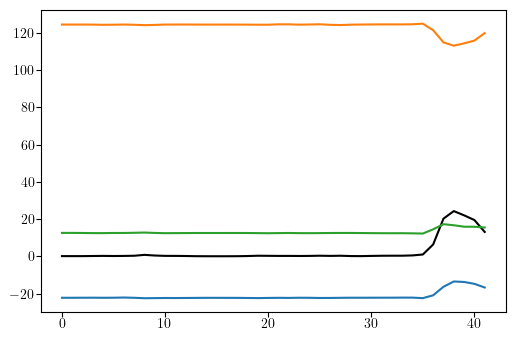

In [8]:
i =57

plt.figure(dpi=100);
plt.plot(df.hDistFromInitPos[i],'k');
plt.plot(df.hTrjB[i][:,:3]);

# Distance moved in intertrial *vs.* execution epoch

In [12]:
def return_distances(df):
    df_ = pyal.restrict_to_interval(df, epoch_fun=defs.fixation_epoch)
    IT_dis = [np.sum(trialD, where=np.logical_not(np.isnan(trialD))) for trialD in df_.hDistFromInitPos]

    df_ = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
    EXE_dis = [np.sum(trialD, where=np.logical_not(np.isnan(trialD))) for trialD in df_.hDistFromInitPos]
    
    return np.array(IT_dis), np.array(EXE_dis)

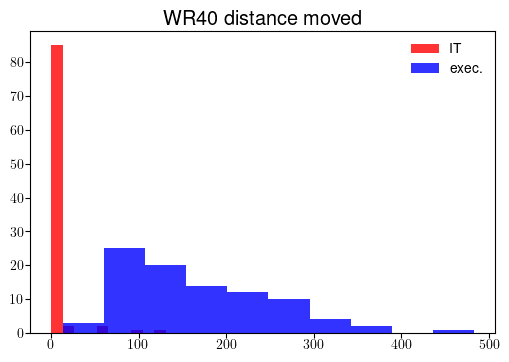

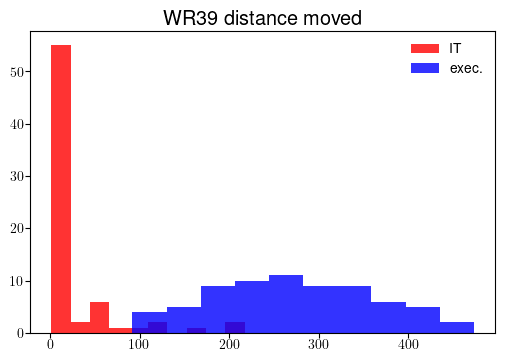

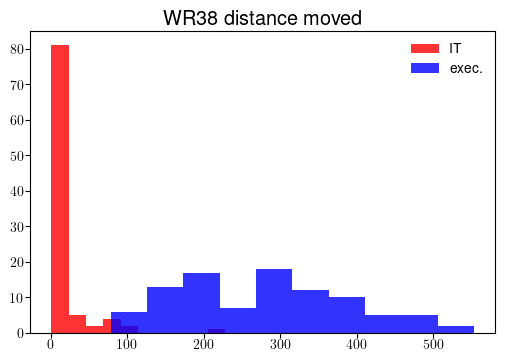

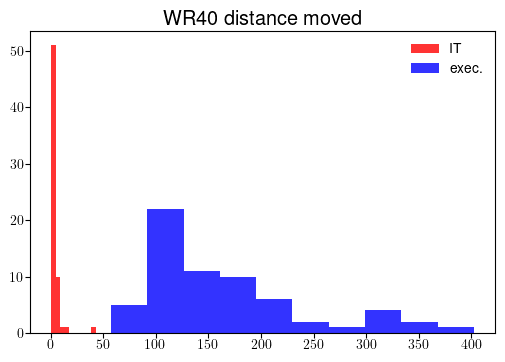

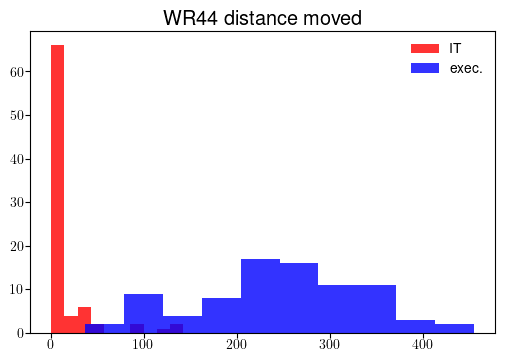

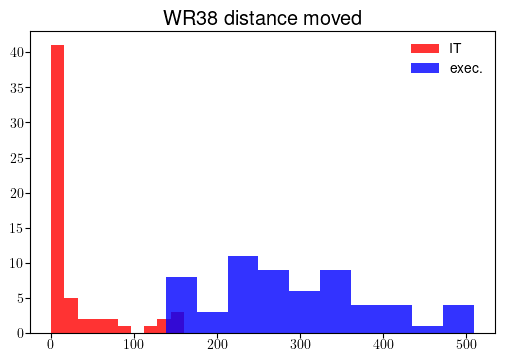

In [18]:
for df in AllDFs:
    IT_dis, EXE_dis= return_distances(df)
    _,ax=plt.subplots(dpi=100)
    ax.hist(IT_dis, color='r', alpha=.8, label='IT')
    ax.hist(EXE_dis,color='b', alpha=.8, label='exec.')
    ax.set_title(fr'{df.mouse[0]} distance moved')
    ax.legend()

just plot the pull phase

In [ ]:
def plot_reach_phase(axes,df):
    for i,traj in enumerate(df.hTrjB):
        if df.target_id[i] in (0,):
            color = 'r'
        elif df.target_id[i] in (2,):
            color = 'b'
        else:
            continue
        axes[0].plot(traj[df.idx_movement_on[i]:df.idx_pull_on[i],0],traj[df.idx_movement_on[i]:df.idx_pull_on[i],1],lw=.5, color=color)
    axes[0].set_title('HEAVY targets --- Reach')

    for i,traj in enumerate(df.hTrjB):
        if df.target_id[i] in (1,):
            color = 'r'
        elif df.target_id[i] in (3,):
            color = 'b'
        else:
            continue
        axes[1].plot(traj[df.idx_movement_on[i]:df.idx_pull_on[i],0],traj[df.idx_movement_on[i]:df.idx_pull_on[i],1],lw=.5, color=color)
    axes[1].set_title('LIGHT targets --- Reach')

In [ ]:
def plot_pull_phase(axes,df):
    for i,traj in enumerate(df.hTrjB):
        if df.target_id[i] in (0,):
            color = 'r'
        elif df.target_id[i] in (2,):
            color = 'b'
        else:
            continue
        axes[0].plot(traj[df.idx_pull_on[i]:,0],traj[df.idx_pull_on[i]:,1],lw=.5, color=color)
    axes[0].set_title('HEAVY targets --- Pull')

    for i,traj in enumerate(df.hTrjB):
        if traj.ndim<2:
            continue
        if df.target_id[i] in (1,):
            color = 'r'
        elif df.target_id[i] in (3,):
            color = 'b'
        else:
            continue
        axes[1].plot(traj[df.idx_pull_on[i]:,0],traj[df.idx_pull_on[i]:,1],lw=.5, color=color)
    axes[1].set_title('LIGHT targets --- Pull')

In [ ]:
# %config InlineBackend.close_figures = True
fig,axes = plt.subplots(1,2,figsize=(15,5))

plot_pull_phase(axes,df)

Plot the *execution* epoch

In [ ]:
def del_nan(a,b):
    a_bad = np.isnan(a)
    b_bad = np.isnan(b)
    bad = np.logical_or(a_bad,b_bad)
    good = np.logical_not(bad)
    
    return a[good], b[good]

def trim_within_mouse_corr(allDF:list[pd.DataFrame],):
    from scipy.stats import pearsonr
    trim_within_corrs = {}
    for df in allDF:
        # df = pyal.restrict_to_interval(df__, epoch_fun=defs.exec_epoch)
        trim_within_corrs[df.file[0]] = []
        targets = np.unique(df.target_id)
        for target in targets:
            df_ = pyal.select_trials(df, df.target_id == target)
            for i, vel1 in enumerate(df_.hTrjB):
                for j, vel2 in enumerate(df_.hTrjB):
                    if j<=i: continue
                    r = [pearsonr(*del_nan(aa,bb))[0] for aa,bb in zip(vel1.T,vel2.T)]
                    trim_within_corrs[df_.file[0]].append(np.mean(np.abs(r)))

    return trim_within_corrs

In [ ]:
def plot_exec_epoch(axes,df):
    df = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
    for i,traj in enumerate(df.hTrjB):
        if df.target_id[i] in (0,):
            color = 'r'
        elif df.target_id[i] in (2,):
            color = 'b'
        else:
            continue
        axes[0].plot(traj[:,0],traj[:,1],lw=.5, color=color)
    axes[0].set_title('HEAVY targets')

    for i,traj in enumerate(df.hTrjB):
        if traj.ndim<2:
            continue
        if df.target_id[i] in (1,):
            color = 'r'
        elif df.target_id[i] in (3,):
            color = 'b'
        else:
            continue
        axes[1].plot(traj[:,0],traj[:,1],lw=.5, color=color)
    axes[1].set_title('LIGHT targets')
    
    m_corr= np.mean(trim_within_mouse_corr([df])[df.file[0]])
    
    axes[0].figure.suptitle(f'trajectory correlation $={m_corr:0.2f}$')

In [ ]:
# %config InlineBackend.close_figures = True
fig,axes = plt.subplots(1,2,figsize=(15,5))

plot_exec_epoch(axes,AllDFs[2])

# plot all the data

In [ ]:
with PdfPages(pathlib.Path.cwd() / 'figures' / 'mouse-traj.pdf') as pdf:
    for df in AllDFs:
        fig,axes = plt.subplots(2,2,figsize=(15,10))
        
        plot_pull_phase(axes[1,:],df)
        plot_reach_phase(axes[0,:],df)
        fig.suptitle(f"Session: {df.file[0].replace('_','-')}")
        
        pdf.savefig()  # saves the current figure into a pdf page
        plt.close()

the pull phase is more consistent:

**check the duration of the pull phase**

In [ ]:
def pull_phase_duration(df):
    light = []
    heavy = []
    for i,traj in enumerate(df.hTrjB):
        if df.target_id[i] in (0,2):
            key = heavy
        elif df.target_id[i] in (1,3):
            key = light
        else:
            continue
        getattr(key,'append')((np.sum(np.logical_not(np.isnan(traj[:,0])))-df.idx_pull_on[i])*df.bin_size[0])

    return light, heavy

    
with PdfPages(pathlib.Path.cwd() / 'figures' / 'mouse-pull-duration.pdf') as pdf:
    for df in AllDFs:
        fig,axes = plt.subplots(1,2,figsize=(10,5))
        
        light, heavy = pull_phase_duration(df)
        axes[0].hist(light)
        axes[0].set_title('light')
        axes[1].hist(heavy)
        axes[1].set_title('heavy')
        
        for ax in axes:
            ax.set_xlim([0,ax.get_xlim()[1]])
            ax.set_xlabel('Pull duration (s)')
            ax.set_ylabel(r'\# of trials')
        
        fig.suptitle(f"Session: {df.file[0].replace('_','-')}")
        
        pdf.savefig()  # saves the current figure into a pdf page
        plt.close()
print('Done')

# Plot average firing rates

In [ ]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(15,10))

signal = 'M1_rates'
signal = 'Str_rates'
for i,df in enumerate(AllDFs):
    ax = plt.subplot(3,3,i+1)    
    if signal not in df.columns: continue
    df_ = pyal.restrict_to_interval(df,epoch_fun=defs.exec_epoch)
    a = pyal.get_average_firing_rates(df_,signal)
    a.sort()
    ax.plot(a[::-1])
    ax.set_title(f'{df_.mouse[0]}, n={a.shape[0]} units')

warnings.filterwarnings("default")

maximum of the firing rates

In [ ]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(15,10))

signal = 'M1_rates'
signal = 'Str_rates'
for i,df in enumerate(AllDFs):
    ax = plt.subplot(3,3,i+1)    
    if signal not in df.columns: continue
    df_ = pyal.restrict_to_interval(df,epoch_fun=defs.exec_epoch)
    a = [np.max(fr,axis=0) for fr in df_[signal]]
    a = np.max(np.array(a),axis=0)
    ax.plot(a)
    ax.set_title(f'{df_.mouse[0]}, n={df_[signal][0].shape[1]} units')

warnings.filterwarnings("default")

PCA explained variance

In [ ]:
plt.figure(figsize=(15,10))
warnings.filterwarnings("ignore")

for i,df in enumerate(AllDFs):
    ax = plt.subplot(3,3,i+1)
    df_ = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
    rates = np.concatenate(df_['Str_rates'].values, axis=0)
    rates_model = PCA(n_components=50, svd_solver='full').fit(rates)
    ax.plot(np.cumsum(rates_model.explained_variance_ratio_))
    ax.set_ylim([0,1])
warnings.filterwarnings("default")

In [ ]:
warnings.filterwarnings("ignore")

plt.figure(figsize=(15,10))
for i,df in enumerate(AllDFs):
    ax = plt.subplot(3,3,i+1)
    df_ = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
    try:
        rates = np.concatenate(df_['M1_rates'].values, axis=0)
    except KeyError:
        continue
    rates_model = PCA(n_components=20, svd_solver='full').fit(rates)
    ax.plot(np.cumsum(rates_model.explained_variance_ratio_))
    ax.set_ylim([0,1])
    
warnings.filterwarnings("default")

Check the number of trials per target

In [ ]:
for df in AllDFs:
    print({df.file[0]})
    for target in np.unique(df.target_id):
        df_ = pyal.select_trials(df, df.target_id == target)
        print(f'target[{target}]: {len(df_.Str_rates)}')
    print()

check the weird session
`js2p0_tbytSpkHandJsTrj10msBin_WR39_100819_np2p0_strOnly_ss`

In [ ]:
animalpath = animalFiles[5]

animalpath

In [ ]:
df = dt.load_pyal_data(animalpath)
df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
df['file'] = fname.split(os.sep)[-1]
# df = prep_general_mouse(df)

# data = dt.get_data_array(df, exec_epoch, area=areas[1], model=10)

In [ ]:
a = df.unitTimeBStr[10]

a.toarray().shape

So this session is in fact binned at 20ms.  
**Remove it totally**

---

# plot hand velocities

In [ ]:
df = AllDFs[1]
plt.plot(df.hVelB[5])